In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7585970845769966998
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15134713447
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12607600811567738422
physical_device_desc: "device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5"
]


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df = pd.read_csv('./train.csv')
print("size of train_df:", len(train_df))

# 데이터 노이즈 수정
train_df.loc[train_df['id'] == 3896, 'artist'] = 'Titian'
train_df.loc[train_df['id'] == 3986, 'artist'] = 'Alfred Sisley'

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last",
    validation_split=0.10
)

TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='artist',
    target_size=(244, 244),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset="training"
)

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='artist',
    target_size=(244, 244),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset="validation"
)

size of train_df: 5911
Found 5320 validated image filenames belonging to 50 classes.
Found 591 validated image filenames belonging to 50 classes.


In [4]:
df = train_df.copy()
df['artist'].apply(lambda s: str(s).split('|'))
label_freq = df['artist'].apply(lambda s: str(s).split('|')).explode().value_counts().sort_values(ascending=False)
display(label_freq)

Vincent van Gogh             629
Edgar Degas                  490
Pablo Picasso                303
Pierre-Auguste Renoir        233
Albrecht Du rer              220
Paul Gauguin                 220
Francisco Goya               204
Rembrandt                    181
Titian                       173
Marc Chagall                 173
Alfred Sisley                164
Paul Klee                    142
Rene Magritte                137
Amedeo Modigliani            132
Andy Warhol                  132
Henri Matisse                121
Sandro Botticelli            120
Mikhail Vrubel               118
Hieronymus Bosch             115
Leonardo da Vinci            101
Salvador Dali                 99
Peter Paul Rubens             97
Kazimir Malevich              91
Pieter Bruegel                85
Frida Kahlo                   84
Diego Velazquez               81
Joan Miro                     76
Andrei Rublev                 74
Raphael                       73
Giotto di Bondone             72
Gustav Kli

In [5]:
artist_df = df.copy()
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(df['artist'].values)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels_encoded), y=labels_encoded)
class_weights_dic = {i: class_weights[i] for i in range(len(class_weights))}
class_weights_dic

{0: 0.5373636363636364,
 1: 0.7208536585365853,
 2: 0.8956060606060606,
 3: 1.5975675675675676,
 4: 0.8956060606060606,
 5: 1.8471875,
 6: 3.694375,
 7: 2.003728813559322,
 8: 2.3644,
 9: 1.4595061728395062,
 10: 0.24126530612244898,
 11: 1.906774193548387,
 12: 2.686818181818182,
 13: 1.8187692307692307,
 14: 4.546923076923077,
 15: 0.5795098039215686,
 16: 1.4073809523809524,
 17: 3.9406666666666665,
 18: 1.6419444444444444,
 19: 1.7133333333333334,
 20: 2.814761904761905,
 21: 0.9770247933884297,
 22: 2.2734615384615386,
 23: 1.9380327868852458,
 24: 1.028,
 25: 5.62952380952381,
 26: 1.8471875,
 27: 1.5555263157894736,
 28: 1.299120879120879,
 29: 1.1704950495049504,
 30: 0.6833526011560693,
 31: 3.4770588235294118,
 32: 1.001864406779661,
 33: 0.39016501650165014,
 34: 3.5824242424242425,
 35: 0.5373636363636364,
 36: 0.8325352112676057,
 37: 1.218762886597938,
 38: 0.5073819742489271,
 39: 2.003728813559322,
 40: 1.3908235294117648,
 41: 1.6194520547945206,
 42: 0.653149171270718

In [6]:
# ResNet50 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(244, 244, 3), pooling=None, input_tensor=None)

# 새로운 Fully Connected Layer 추가
x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x) # 드롭아웃 추가
predictions = Dense(50, activation='softmax')(x)

#전체 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)


# 모델 컴파일
model.compile(optimizer=Adam(lr=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
CP = ModelCheckpoint(filepath='resnet50_model/' + 'ResNet50-Sigmoid-{epoch:03d}-{loss:.4f}-{val_loss:.4f}.hdf5',
                     monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.00005)
CALLBACK = [CP, LR]

In [8]:
# 모델 학습
history = model.fit(
    TRAIN_GENERATOR,
    epochs=20,
    validation_data=VALID_GENERATOR,
    callbacks=CALLBACK,
    class_weight=class_weights_dic
)

Train for 167 steps, validate for 19 steps
Epoch 1/20
166/167 [============================>.] - ETA: 0s - loss: 4.1422 - accuracy: 0.2457
Epoch 00001: val_loss improved from inf to 4.56399, saving model to resnet50_model/ResNet50-Sigmoid-001-4.1211-4.5640.hdf5
167/167 [==============================] - 141s 844ms/step - loss: 4.1319 - accuracy: 0.2461 - val_loss: 4.5640 - val_accuracy: 0.0152
Epoch 2/20
166/167 [============================>.] - ETA: 0s - loss: 2.3333 - accuracy: 0.4366
Epoch 00002: val_loss did not improve from 4.56399
167/167 [==============================] - 127s 760ms/step - loss: 2.3289 - accuracy: 0.4370 - val_loss: 5.9826 - val_accuracy: 0.0355
Epoch 3/20
166/167 [============================>.] - ETA: 0s - loss: 2.1080 - accuracy: 0.4868
Epoch 00003: val_loss did not improve from 4.56399
167/167 [==============================] - 127s 762ms/step - loss: 2.1072 - accuracy: 0.4865 - val_loss: 11.8248 - val_accuracy: 0.0102
Epoch 4/20
166/167 [==================

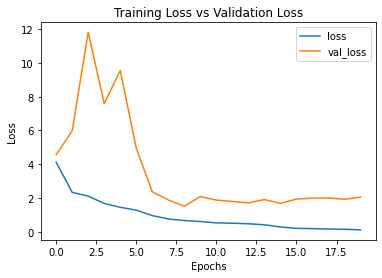

In [9]:
# 손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

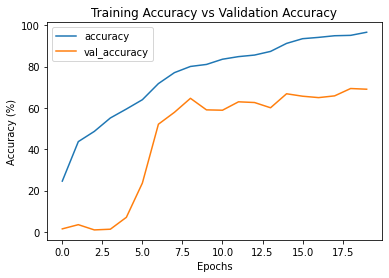

In [10]:
# 정확도 그래프
plt.plot([x * 100 for x in history.history['accuracy']])
plt.plot([x * 100 for x in history.history['val_accuracy']])
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [11]:
# 최신 체크포인트 파일 찾기
checkpoint_files = glob.glob('resnet50_model/*.hdf5')
latest_checkpoint = max(checkpoint_files, key=os.path.getctime)

# 모델에 최신 가중치 로드
model.load_weights(latest_checkpoint)

# Validation 데이터에 대한 정확도 확인
val_loss, val_accuracy = model.evaluate(VALID_GENERATOR)
print('Validation Loss:', round(val_loss, 6))
print('Validation Accuracy:', round(val_accuracy, 3))

19/19 [==============================] - 10s 510ms/step - loss: 1.4769 - accuracy: 0.6413
Validation Loss: 1.47692
Validation Accuracy: 0.641


In [12]:
test_df = pd.read_csv('test.csv')

TEST_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=test_df,
    x_col='img_path',
    y_col='id',
    target_size=(244, 244),
    class_mode='raw',
    batch_size=32,
    shuffle=False,
)

TEST_GENERATOR.reset()

# 최신 체크포인트 파일 찾기
checkpoint_files = glob.glob('resnet50_model/*.hdf5')
latest_checkpoint = max(checkpoint_files, key=os.path.getctime)

print(latest_checkpoint)

# 모델에 최신 가중치 로드
model.load_weights(latest_checkpoint)

test_prediction = model.predict(TEST_GENERATOR, verbose=1)
display(test_prediction)

Found 12670 validated image filenames.
resnet50_model\ResNet50-Sigmoid-009-0.6597-1.5066.hdf5
396/396 [==============================] - 174s 441ms/step


array([[3.13822390e-03, 1.08525506e-03, 5.00381272e-03, ...,
        5.86338101e-05, 7.23905042e-02, 1.31625755e-04],
       [1.01831756e-05, 2.60676984e-06, 7.39708483e-01, ...,
        2.16293665e-05, 1.16748195e-02, 3.02134595e-06],
       [1.57303330e-05, 2.65440940e-05, 1.04671494e-06, ...,
        2.07584162e-05, 1.14435598e-03, 9.69475004e-05],
       ...,
       [5.18766137e-06, 2.23627428e-08, 4.28618133e-01, ...,
        7.89221076e-07, 7.47398473e-03, 1.79149424e-07],
       [7.93135259e-05, 1.89118400e-05, 2.60605477e-04, ...,
        4.91314631e-06, 2.68286956e-03, 1.21204639e-05],
       [1.36092879e-07, 3.70669291e-08, 2.01127750e-06, ...,
        2.62664357e-09, 9.96448874e-01, 3.01930658e-09]], dtype=float32)

In [13]:
test_prediction = np.argmax(test_prediction, axis = 1)
test_prediction

array([46,  2, 46, ..., 33, 46, 48], dtype=int64)

In [14]:
test_prediction_df = pd.DataFrame(test_prediction, columns = ['artist'])
test_prediction_df

,artist
0,46
1,2
2,46
3,0
4,12
...,...
12665,10
12666,9
12667,33
12668,46


In [15]:
artist_df = train_df.copy()
artist_le = label_encoder.fit_transform(artist_df['artist'].values)
artist_df['num'] = artist_le
artist_df = artist_df.drop('id', axis=1)
artist_df = artist_df.drop('img_path', axis=1)
test_prediction_dic = test_prediction_df.to_dict()
test_prediction_values = test_prediction_dic['artist'].values()
test_prediction_list = list(test_prediction_values)
artist_df.set_index('num', inplace=True)
artist_df = artist_df.sort_index()
artist_info_dic = artist_df['artist'].to_dict()

In [16]:
artist_name = []
for i in test_prediction_list:
    artist_name.append(artist_info_dic[i])
artist_name[:5]

['Titian', 'Amedeo Modigliani', 'Titian', 'Albrecht Du rer', 'Edvard Munch']

In [17]:
submission_df = pd.read_csv("./sample_submission.csv")
submission_df = submission_df.drop('artist', axis=1)
submission_df['artist'] = artist_name
submission_df.head()

,id,artist
0,TEST_00000,Titian
1,TEST_00001,Amedeo Modigliani
2,TEST_00002,Titian
3,TEST_00003,Albrecht Du rer
4,TEST_00004,Edvard Munch


In [18]:
submission_df.to_csv("resnet50_submission.csv", index=False)